# RANDOM FOREST CLASSIFIER

### Classifies forest cover into dominating tree species and age groups from hyperdimensional satellite imagery  

In [1]:
# MODULE
import os                                                   # DESCRIPTION
import numpy as np                                              # scientific computing
#import matplotlib as mtp                                        # create visualizations
import matplotlib.pyplot as plt                                 # create visualizations
import pandas as pd                                              # data analysis and manipulation
import geopandas as gpd
from pathlib import Path                                     # extends the datatypes used by pandas to allow spatial operations on geom. types


import rasterio                                                 # Rasterio reads and writes raster formats and provides a Python API based
from rasterio.plot import reshape_as_raster, reshape_as_image   # on Numpy N-dimensional arrays and GeoJSON

# turns on 'nline plotting', where plot graphics will appear in the notebook below the cell that produced them.
%matplotlib inline

# Change module setting
pd.options.display.max_colwidth = 80       # Longer text in pd.df


### Set up paths to data

* Sentinel2 & Sentinel1 data fusion product (GEOTIff), __36 BANDS__
* Data with training data (geopackages), 2000 points per age/species class, __49 553 samples__

In [2]:
# Path to preprocessed and co-located Sentinel-1 and Sentinel-2 stack
S1_S2_stack = Path('Data\Processing\Layer_stack_sentinel_2_10_bands.tif')

# Path to Training and Validation point shapefiles
training_points = Path(r'Data/Training_data/300_points_selected.gpkg')
validation_points = Path(r'Data/Training_data/50_points_selected.gpkg')
workFolder= Path(r'Results/')

# modify class names when changing the classification scheme
class_names = [r'Rohttaimed', r'Talinisu allakülvita', r'Liblikõieliste ja kõrreliste segu (30-80% liblikõielisi)', 'Suvioder allakülvita', r'Kõrreliste rohumaa (vähemalt 80% kõrrelisi)', r'Põldhernes, v.a "Mehis" (100% põldhernest)', 'talioder allakülvita', 'taliraps allakülvita', 'suvinisu allakülvita', r'punane ristik (100% ristikut)', 'kaer allakülvita', 'põlduba, v.a "Jõgeva"', 'muu heintaimede segu', 'rukis, v.a sangaste rukis, allakülvita', r'punane ristik (ristikut 50-80%, teisi heintaimi 20-50%)',  'tatar allakülvita', 'kaer liblikõieliste allakülviga', 'suviraps allakülvita', 'suvioder liblikõieliste allakülviga', 'mais', r'harilik lutsern (lutserni 50-80%, teisi heintaimi 20-50%)', 'talirüps allakülvita', 'forest', 'water', 'built_up']  # Thenty-six classes represented in our training data.

## Load the dataset into rasterio, to be able to manipulate it

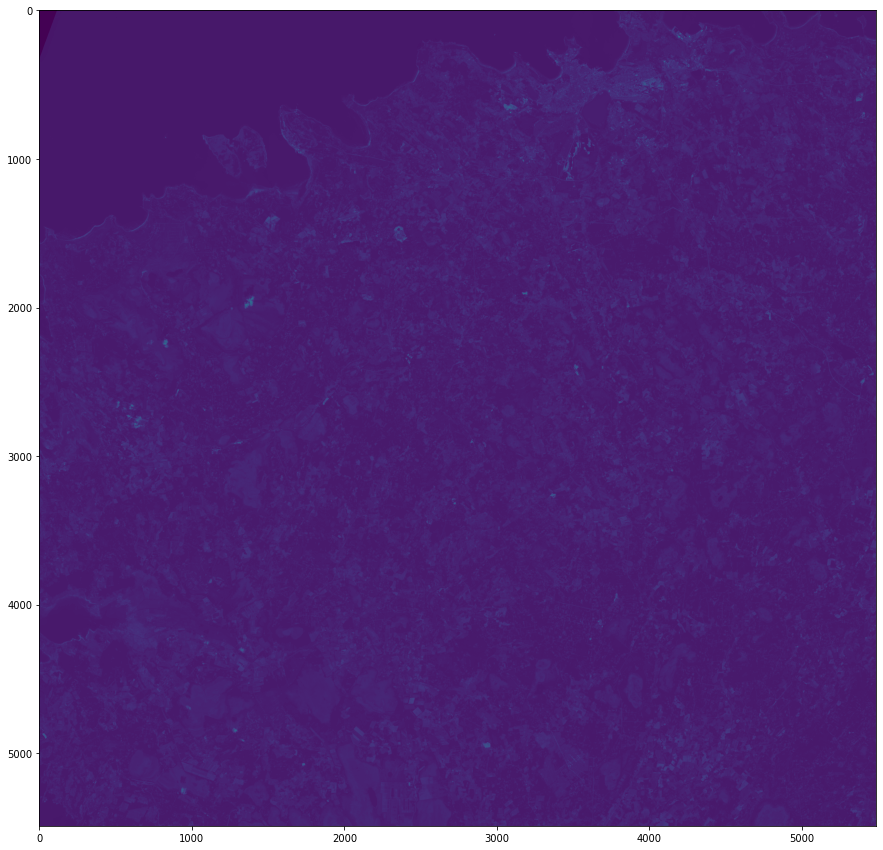

In [3]:
# Loads the input dataset into a dataset object
dataset = rasterio.open(S1_S2_stack)
# to be used later, when cutting the images for final classification
width= dataset.read().shape[2]
height= dataset.read().shape[1]

plt.figure(figsize = (15,15))
plt.imshow(dataset.read(1), aspect='auto')

## Organize the bands into a set, assign meaningful names

In [4]:
# count the bands, assign names to be used
def getBands(count):
    bandList=[]
    prefix= 'band_'
    for i in range(count):
        bandList.append(prefix+str(i))
    return bandList
bands=getBands(dataset.read().shape[0])


# Get the training dataset, used to fit the model
* ## Read points from shapefile
* ## Sample the each band of raster dataset at each point in the coordinate list
* ## Save out the training dataset
* ## Visualize the first rows of the dataframe

In [5]:
train_pts = gpd.read_file(training_points)
train_pts = train_pts[['CLASS', 'UTM_E', 'UTM_N', 'geometry']]  # These are the attributes in our point dataset
train_pts.index = range(len(train_pts))
coords = [(x,y) for x, y in zip(train_pts.UTM_E, train_pts.UTM_N)]  # Create list of point coordinates

train_pts['Raster Value'] = [x for x in dataset.sample(coords)]
train_pts[bands] = pd.DataFrame(train_pts['Raster Value'].tolist(), index= train_pts.index)
train_pts = train_pts.drop(['Raster Value'], axis=1)

sortedClasses= train_pts['CLASS'].unique().tolist()
sortedClasses.sort()

classList=train_pts['CLASS']
for i,v in  enumerate(sortedClasses):
    classList[:] = [x if x != v else i for x in classList]


train_pts['CLASS'] = classList
train_pts.to_csv(workFolder / 'train_pts.csv') # save our training dataset to CSV
# Check if class numbers were correctly changed
train_pts['CLASS'].unique()

train_pts.head() # visualize the first rows of the dataframe

<ipython-input-5-f3431b186c1e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classList[:] = [x if x != v else i for x in classList]


,CLASS,UTM_E,UTM_N,geometry,band_0,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9
0,24,409351.207052,6.516863e+06,POINT (409351.207 6516863.400),1544,1684,1322,4816,2297,3968,4385,4847,3395,2232
1,24,409325.184520,6.519801e+06,POINT (409325.185 6519801.196),1404,1522,1340,4357,1812,3556,4022,4145,2538,1809
2,24,409357.548727,6.519799e+06,POINT (409357.549 6519799.381),1258,1493,1219,5132,1871,3776,4578,4534,2684,1871
3,24,409291.596038,6.519913e+06,POINT (409291.596 6519913.083),1504,1544,1463,3326,2008,2786,3236,3176,2662,2179
4,24,405030.294709,6.578224e+06,POINT (405030.295 6578223.754),2106,2118,2002,3976,2287,3109,3452,3537,3157,2553


## Split training dataset to labels (y) and input features (x) !!

In [6]:
y = train_pts['CLASS'].values
x = train_pts[bands].values
del(train_pts, coords)
print('The trainng data sizes are: Sentinel-1 and Sentinel-2 stack: : ', x.shape,
)


The trainng data sizes are: Sentinel-1 and Sentinel-2 stack: :  (7500, 10)


## Process the validation dataset, used to test the model fit.
* ### Read points from shapefile
* ### Sample the each band of raster dataset at each point in the coordinate list
* ### Save out the validation dataset

In [7]:
# Get the validation dataset, used to test the model fit.
# Read points from shapefile
valid_pts = gpd.read_file(validation_points)
valid_pts = valid_pts[['CLASS', 'UTM_E', 'UTM_N', 'geometry']]  # These are the attributes in our point dataset
valid_pts.index = range(len(valid_pts))
coords = [(x,y) for x, y in zip(valid_pts.UTM_E, valid_pts.UTM_N)]  # Create list of point coordinates

valid_pts['Raster Value'] = [x for x in dataset.sample(coords)]   # all band values are saved as a list in the Raster Value column

valid_pts[bands] = pd.DataFrame(valid_pts['Raster Value'].tolist(), index= valid_pts.index)

valid_pts = valid_pts.drop(['Raster Value'], axis=1)  # Remove Raster Value column

valid_pts['CLASS'] = valid_pts['CLASS'].replace(sortedClasses,range(len(sortedClasses)))
valid_pts.to_csv(workFolder / 'valid_pts.csv')   # save our validation dataset to CSV
valid_pts.head()   # visualize the first rows of the dataframe


,CLASS,UTM_E,UTM_N,geometry,band_0,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9
0,24,408414.236380,6.591280e+06,POINT (408414.236 6591279.892),2804,2592,2434,3418,3560,3630,3699,4015,3787,3579
1,24,408316.201539,6.591336e+06,POINT (408316.202 6591335.755),2388,2150,1850,3818,2583,3288,3415,3716,3718,2963
2,24,408394.130903,6.591313e+06,POINT (408394.131 6591313.316),3534,3348,3402,3880,3100,3124,3370,3489,3688,3428
3,24,387796.943068,6.594800e+06,POINT (387796.943 6594799.580),2180,2070,1856,3548,2350,3182,3298,3554,3038,2525
4,24,387591.663391,6.594899e+06,POINT (387591.663 6594899.045),1514,1512,1380,3202,1852,2785,3132,3165,2724,2216


# Split validation dataset to labels (y) and input features (x)

In [8]:
y_valid = valid_pts['CLASS'].values
x_valid = []
x_valid= valid_pts[bands].values  # Sentinel-2 data
del(valid_pts, coords)
print('The validation data sizes are: Sentinel-1 and Sentinel-2 stack: ', x_valid.shape,
      )

The validation data sizes are: Sentinel-1 and Sentinel-2 stack:  (1250, 10)


# Close the image dataset, to free up resources for the random forest algorithm procesing!!!!


In [9]:
dataset.close()

# RANDOM FOREST CLASSIFIER


## Set the parameters
__POSSIBLE PARAMETERS__:
 * n_estimators=500,
 * criterion='gini'/'entropy'
 * max_depth=None
 * min_samples_split=2
 * min_samples_leaf=1
 * min_weight_fraction_leaf=0.0
 * max_features='auto'
 * max_leaf_nodes=None
 * min_impurity_decrease=0.0
 * min_impurity_split=None
 * bootstrap=True
 * oob_score=False
 * n_jobs=None
 * random_state=None
 * verbose=0
 * warm_start=False
 * class_weight=None
 * ccp_alpha=0.0
 * max_samples=None


#### We initialize our model with 500 trees and the default parameters

In [10]:
from sklearn.ensemble import RandomForestClassifier # import random forest

rf = RandomForestClassifier(n_estimators=100, criterion='entropy', oob_score=True, max_features='sqrt')
rf = rf.fit(x, y)   # Fit the model to the training dataset

# The OOB score of the training dataset obtained using an out-of-bag estimate.
print('Our OOB prediction of accuracy for S1 and S2 stack is: {oob}%'.format(oob=rf.oob_score_ * 100))


Our OOB prediction of accuracy for S1 and S2 stack is: 45.48%


# Model validation!

* ### Run prediction on the test datastet
* ### Print confusion matrix
* ### Evaluate result

<Axes: >

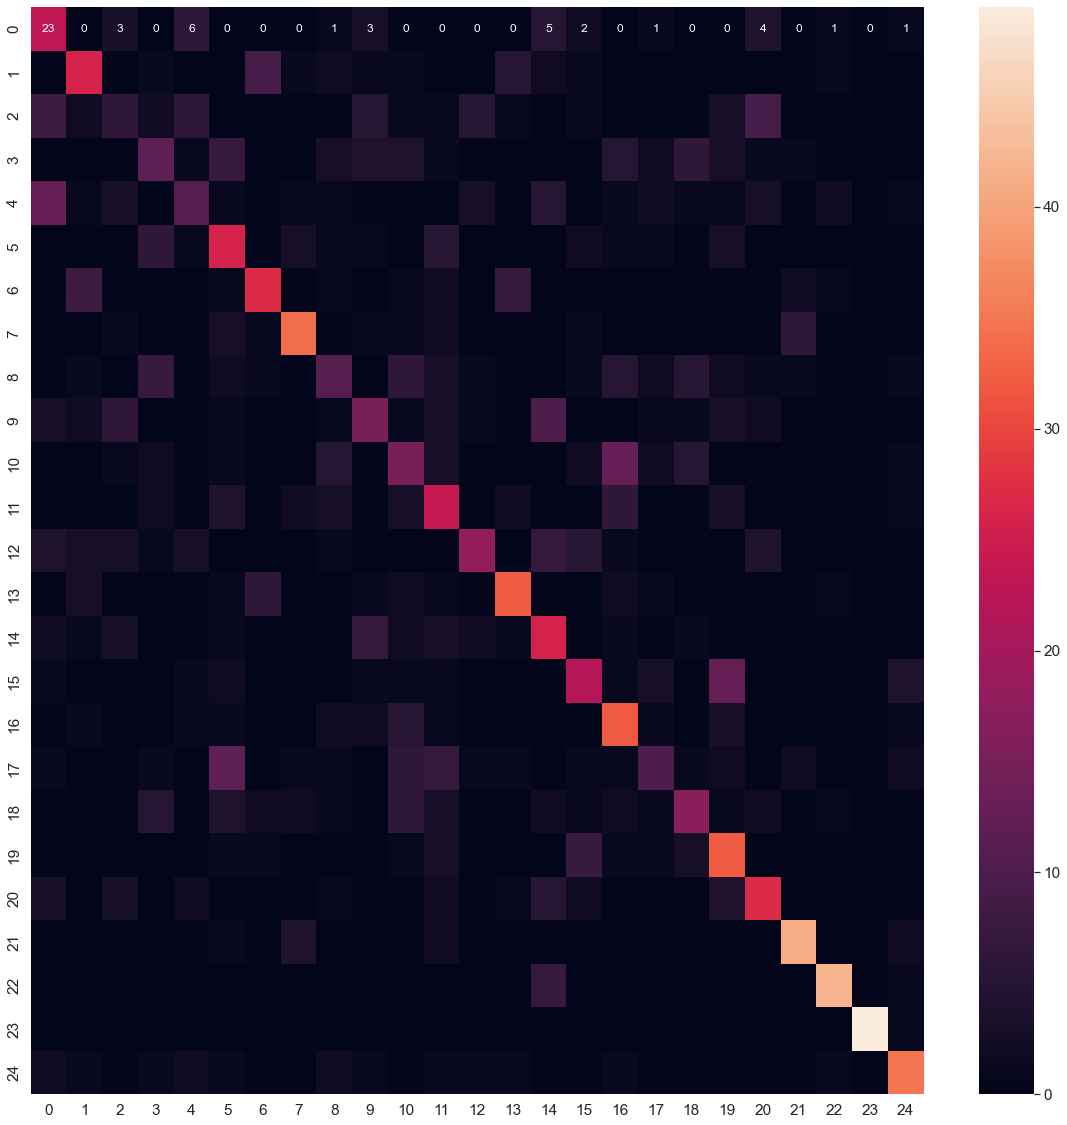

In [11]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

label = ['Sentinel-2 stack']
# Run prediction on the test datastet
y_pred = rf.predict(x_valid)
report= classification_report(y_valid, y_pred, target_names=class_names,output_dict=True)
confusionMatrix=confusion_matrix(y_valid, y_pred)
reportDataframe = pd.DataFrame(report)
confusionMatrixDataframe= pd.DataFrame(confusionMatrix)
classnames=pd.DataFrame([sortedClasses,class_names])

reportDataframe.to_csv(workFolder / 'validation_report.csv')
confusionMatrixDataframe.to_csv(workFolder / 'confusion_matrix.csv')
classnames.to_csv(workFolder / 'classificationIndex.csv')


plt.figure(figsize = (20,20))
sn.set(font_scale=1.4) # label size
sn.heatmap(confusionMatrixDataframe, annot=True, annot_kws={"size": 12}) # font size




# The next steps are will be very RAM intensive!

* ### Splitting the original image in individual pieces, to enable processing with less RAM


In [12]:
import math
import itertools
def cutImageWindows(rasterHeight,rasterWidth, splitFactor):
  print("Starting window calculation")
  wholeImageWindow = rasterio.windows.Window(col_off=0, row_off=0,
                           width=rasterWidth, height=rasterHeight)

  rasterWindows= []
  window_count= splitFactor^2
  windowHeight=rasterHeight/splitFactor
  windowWidth= rasterWidth/splitFactor
  col_row_offsets = itertools.product(range(0, rasterWidth, int(math.ceil(windowWidth))), range(0, rasterHeight, int(math.ceil(windowHeight))))
  for col_off, row_off in col_row_offsets:
    rasterWindow = rasterio.windows.Window(col_off=col_off, row_off=row_off,
                             width=windowWidth, height=windowHeight)
    #print("Window intersection calc")
    rasterWindow = rasterWindow.intersection(wholeImageWindow) # must be inside image
    rasterWindows.append(rasterWindow)
  print("Done processing raster windows")
  return rasterWindows

def getClassificationImagesfromWindows(dataset, rasterWindow):
  image= dataset.read(window=rasterWindow)
  reshaped_img = reshape_as_image(image)
  img_shape= reshaped_img[:,:,0].shape
  class_input_S1S2 = reshaped_img.reshape(-1, x.shape[1])
  return (class_input_S1S2,img_shape)

## Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
## You may need to reduce image size (increase split factor) if your kernel crashes, as the next steps- classification itself- step takes a lot of memory

In [13]:

splitFactor= 5 # set to dertermine how much to compress the picture.
rasterWindows= cutImageWindows(height,width, splitFactor)

Starting window calculation
Done processing raster windows


# Sentinel-1 and Sentinel-2 stack classification !!!!

In [14]:
print("Starting the prediction!")
print("Number of windows to process: ", len(rasterWindows))
dataset = rasterio.open(S1_S2_stack)
predictionImages=[]
for index in range(len(rasterWindows)):
  print("Started prediction in window ", index)
  window_Image= getClassificationImagesfromWindows(dataset, rasterWindows[i])
  class_RF_S1S2 = rf.predict(window_Image[0])
  # Reshape our classification map back into a 2D matrix so we can visualize it
  shape= window_Image[1]
  class_RF_S1S2 = class_RF_S1S2.reshape(shape)
  predictionImages.append((class_RF_S1S2,rasterWindows[i]))

Starting the prediction!
Number of windows to process:  25
Started prediction in window  0
Started prediction in window  1
Started prediction in window  2
Started prediction in window  3


KeyboardInterrupt: 

## Combine the single images into final result!!!

In [ ]:
final_classification= workFolder / 'RF_classification.tif'
with rasterio.Env():
    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = dataset.profile
    # change the band count to 1, set the dtype to uint8, and specify LZW compression.
    profile.update(dtype=rasterio.uint8,count=1, compress='lzw')
    with rasterio.open(final_classification, 'w', **profile) as dst:
      n=0
      for image in predictionImages:
        dst.write(image[0].astype(rasterio.uint8), 1, window=image[1])
        n=n+1

classification_image = rasterio.open(final_classification)
plt.figure(figsize = (15,15))
plt.imshow(classification_image.read(1), aspect='auto', cmap="gist_rainbow")

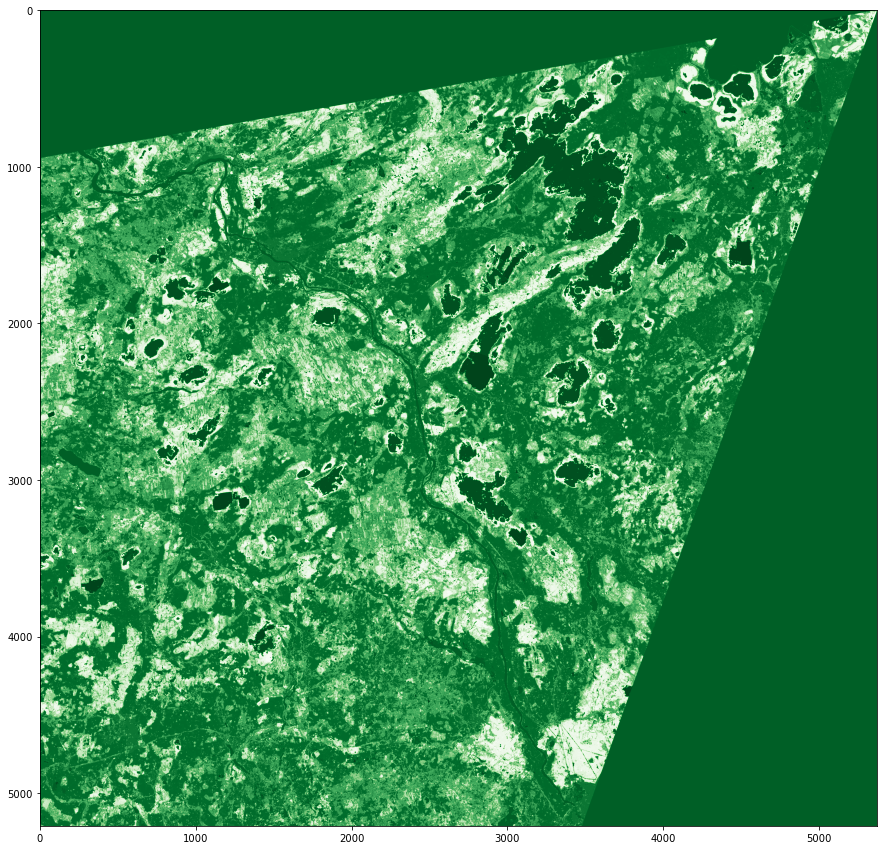

In [ ]:
final_classification= workFolder / 'RF_classification.tif'
classification_image = rasterio.open(final_classification)
plt.figure(figsize = (15,15))
plt.imshow(classification_image.read(1), aspect='auto', cmap="Greens")

## Results available [pushkinStreet Geoserver](http://pushkin.hopto.org/forest)